In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math

class RootData:
    def __init__(self, file_path):
        self.file = uproot.open(file_path)
        self._load_data()
        self.file_path = file_path

    def _validate_indices(self, indices, max_index):
        for index in indices:
            if index < 1 or index > max_index:
                raise ValueError(f"Index {index} out of range. Valid range is 1 to {max_index}.")
            
    def _load_data(self):
        self.Ntuples = {}
        self.H1 = {}
        self.H2 = {}

        # 前面若干是Ntuple，后面4个是H1，最后一个是H2
        keys = self.file.keys()
        ntuple_keys = keys[:-5]
        h1_keys = keys[-5:-1]
        h2_key = keys[-1]

        # 加载Ntuple数据
        for i, key in enumerate(ntuple_keys, start=1):
            ntuple = self.file[key]
            try:
                df = ntuple.arrays(library="pd")
                self.Ntuples[f'N_{i}'] = df
            except ValueError as e:
                print(f"Error loading {key}: {e}")
                continue
        
        # 加载H1数据
        for i, key in enumerate(h1_keys, start=1):
            h1 = self.file[key]
            h1_data = h1.to_numpy()
            h1_values = h1_data[0]
            h1_edges = h1_data[1]
            self.H1[f'H1_{i}'] = (h1_values, h1_edges)

        # 加载H2数据
        h2 = self.file[h2_key]
        h2_values = h2.values()
        h2_edges = np.histogram2d(h2_values[:, 0], h2_values[:, 1])[1:]  # 使用 numpy.histogram2d 获取边界
        self.H2['H2'] = (h2_values, h2_edges)
        
        # Print 文件基本信息，比如有多少个Ntuples
        print(f"File contains {len(self.Ntuples)} Ntuples.")
        print(f"File contains {len(self.H1)} H1 histograms.")
        print(f"File contains 1 H2 histogram.")
        
        

    def plot_ntuple(self, indices_to_plot=None):
        if indices_to_plot is None:
            indices_to_plot = range(1, len(self.Ntuples) + 1)
        else:
            self._validate_indices(indices_to_plot, len(self.Ntuples))

        for i in indices_to_plot:
            ntuple_name = f'N_{i}'
            df = self.Ntuples[ntuple_name]
            for column in df.columns:
                plt.figure(figsize=(8, 6))
                plt.hist(df[column], bins=50, alpha=0.7, label=column)
                plt.xlabel(column)
                plt.ylabel("Entries")
                plt.title(f"Histogram of {column} from {ntuple_name}")
                plt.legend()
                plt.show()

    def plot_h1(self):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        for i, (h1_name, (values, edges)) in enumerate(self.H1.items()):
            ax = axs[i // 2, i % 2]
            ax.bar(edges[:-1], values, width=edges[1] - edges[0])
            ax.set_title(h1_name)
        plt.tight_layout()
        plt.show()

    def plot_h2(self):
        values, edges = self.H2['H2']
        plt.figure(figsize=(8, 6))
        plt.imshow(values, extent=[edges[0][0], edges[0][-1], edges[1][0], edges[1][-1]], aspect='auto', origin='lower')
        plt.colorbar()
        plt.title('H2')
        plt.xlabel("X axis")
        plt.ylabel("Y axis")
        plt.show()

    def save_layers_mean(self, filename):
        # 获取 Ntuples 的数量
        num_ntuples = len(self.Ntuples)
        # 获取字段名
        try:
            fields = self.Ntuples['N_2'].keys()
        except KeyError:
            print("未找到 'N_2' 字段，无法获取 layers 数据。")
            return
        data = []
        for i in range(2, num_ntuples + 1):
            try:
                ntuple = self.Ntuples[f'N_{i}']
            except KeyError as e:
                print(f"Error accessing Ntuple {i}: {e}")
                continue
            row = [i-2]  # 第一列是 layers，从第0层开始
            for field in fields:
                mean_value = ntuple[field].mean()
                row.append(mean_value)
            data.append(row)

        # 创建 DataFrame
        columns = ['layers'] + list(fields)
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(filename, index=False)
    
    def save(self, filename):
        # 创建文件夹
        base_folder = os.path.splitext(filename)[0]
        figure_folder = os.path.join(base_folder, 'figure')
        data_folder = os.path.join(base_folder, 'data')
        os.makedirs(figure_folder, exist_ok=True)
        os.makedirs(data_folder, exist_ok=True)

        # 保存Ntuple数据
        for ntuple_name, df in self.Ntuples.items():
            for column in df.columns:
                file_path = os.path.join(data_folder, f'{ntuple_name}_{column}.csv')
                df[[column]].to_csv(file_path, index=False)

        mean_data_filename = os.path.join(base_folder, 'layers_mean.csv')
        self.save_layers_mean(mean_data_filename)
        
        # 保存H1数据
        for h1_name, (values, edges) in self.H1.items():
            file_path = os.path.join(data_folder, f'{h1_name}.csv')
            h1_df = pd.DataFrame({'values': values, 'edges': edges[:-1]})
            h1_df.to_csv(file_path, index=False)

        # 保存H2数据
        h2_values, h2_edges = self.H2['H2']
        h2_df = pd.DataFrame(h2_values)
        h2_df.to_csv(os.path.join(data_folder, 'H2_values.csv'), index=False)
        np.savetxt(os.path.join(data_folder, 'H2_edges_x.csv'), h2_edges[0], delimiter=',')
        np.savetxt(os.path.join(data_folder, 'H2_edges_y.csv'), h2_edges[1], delimiter=',')

        # 保存图像
        for ntuple_name, df in self.Ntuples.items():
            for column in df.columns:
                plt.figure(figsize=(8, 6))
                plt.hist(df[column], bins=50, alpha=0.7, label=column)
                plt.xlabel(column)
                plt.ylabel("Entries")
                plt.title(f"Histogram of {column} from {ntuple_name}")
                plt.legend()
                plt.savefig(os.path.join(figure_folder, f'{ntuple_name}_{column}.png'))
                plt.close()

        for h1_name, (values, edges) in self.H1.items():
            plt.figure(figsize=(8, 6))
            plt.bar(edges[:-1], values, width=edges[1] - edges[0])
            plt.title(h1_name)
            plt.savefig(os.path.join(figure_folder, f'{h1_name}.png'))
            plt.close()

        values, edges = self.H2['H2']
        plt.figure(figsize=(8, 6))
        plt.imshow(values, extent=[edges[0][0], edges[0][-1], edges[1][0], edges[1][-1]], aspect='auto', origin='lower')
        plt.colorbar()
        plt.title('H2')
        plt.xlabel("X axis")
        plt.ylabel("Y axis")
        plt.savefig(os.path.join(figure_folder, 'H2.png'))
        plt.close()



In [15]:
# 使用示例
root_data = RootData("../build/e-_2.0MeV_10000-wrongNaI(1).root")

# 直接画图
# root_data.plot_ntuple([1,2])
# root_data.plot_h1()
# root_data.plot_h2()

# 保存数据和图像
fileName = "Test_output7"
root_data.save(fileName)

File contains 33 Ntuples.
File contains 4 H1 histograms.
File contains 1 H2 histogram.


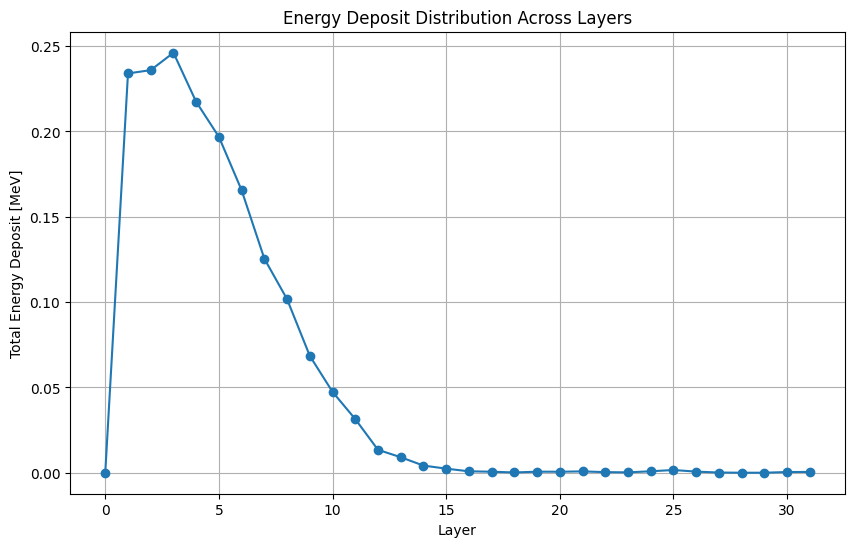

In [16]:
data_folder = fileName+'/data'

# 初始化一个空的 DataFrame 用于存储所有层的数据
all_data = pd.DataFrame()

# 读取文件名到列表中
file_list = [file_name for file_name in os.listdir(data_folder) if file_name.startswith('N_') and file_name.endswith('_energyDeposit.csv')]

# 按文件名中的层号排序
file_list.sort(key=lambda x: int(x.split('_')[1]))

# 遍历文件列表，从层号2开始
eng_list = []
x_list = range(0,len(file_list)) 
for file_name in file_list:
    file_path = os.path.join(data_folder, file_name)
    data = pd.read_csv(file_path)
    eng_list.append(data.sum())

eng_list = np.array(eng_list) / len(data)

# 绘制沉积能量分布图
plt.figure(figsize=(10, 6))
plt.plot(x_list, eng_list, marker='o')
plt.xlabel('Layer')
plt.ylabel('Total Energy Deposit [MeV]')
plt.title('Energy Deposit Distribution Across Layers')
plt.grid(True)
plt.show()

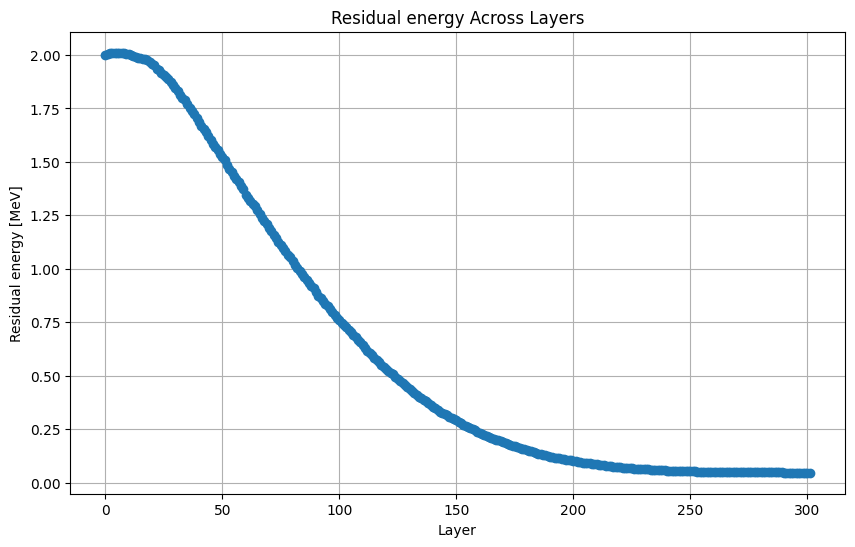

In [4]:
data_folder = fileName+'/data'

# 初始化一个空的 DataFrame 用于存储所有层的数据
all_data = pd.DataFrame()

# 读取文件名到列表中
file_list = [file_name for file_name in os.listdir(data_folder) if file_name.startswith('N_') and file_name.endswith('_PassingEnergy.csv')]

# 按文件名中的层号排序
file_list.sort(key=lambda x: int(x.split('_')[1]))

# 遍历文件列表，从层号2开始
eng_list = []
x_list = range(0,len(file_list)) 
for file_name in file_list:
    file_path = os.path.join(data_folder, file_name)
    data = pd.read_csv(file_path)
    eng_list.append(data.sum())

eng_list = np.array(eng_list) / len(data)

plt.figure(figsize=(10, 6))
plt.plot(x_list, eng_list, marker='o')
plt.xlabel('Layer')
plt.ylabel('Residual energy [MeV]')
plt.title('Residual energy Across Layers') # Total energy passing through the layer
plt.grid(True)
plt.show()

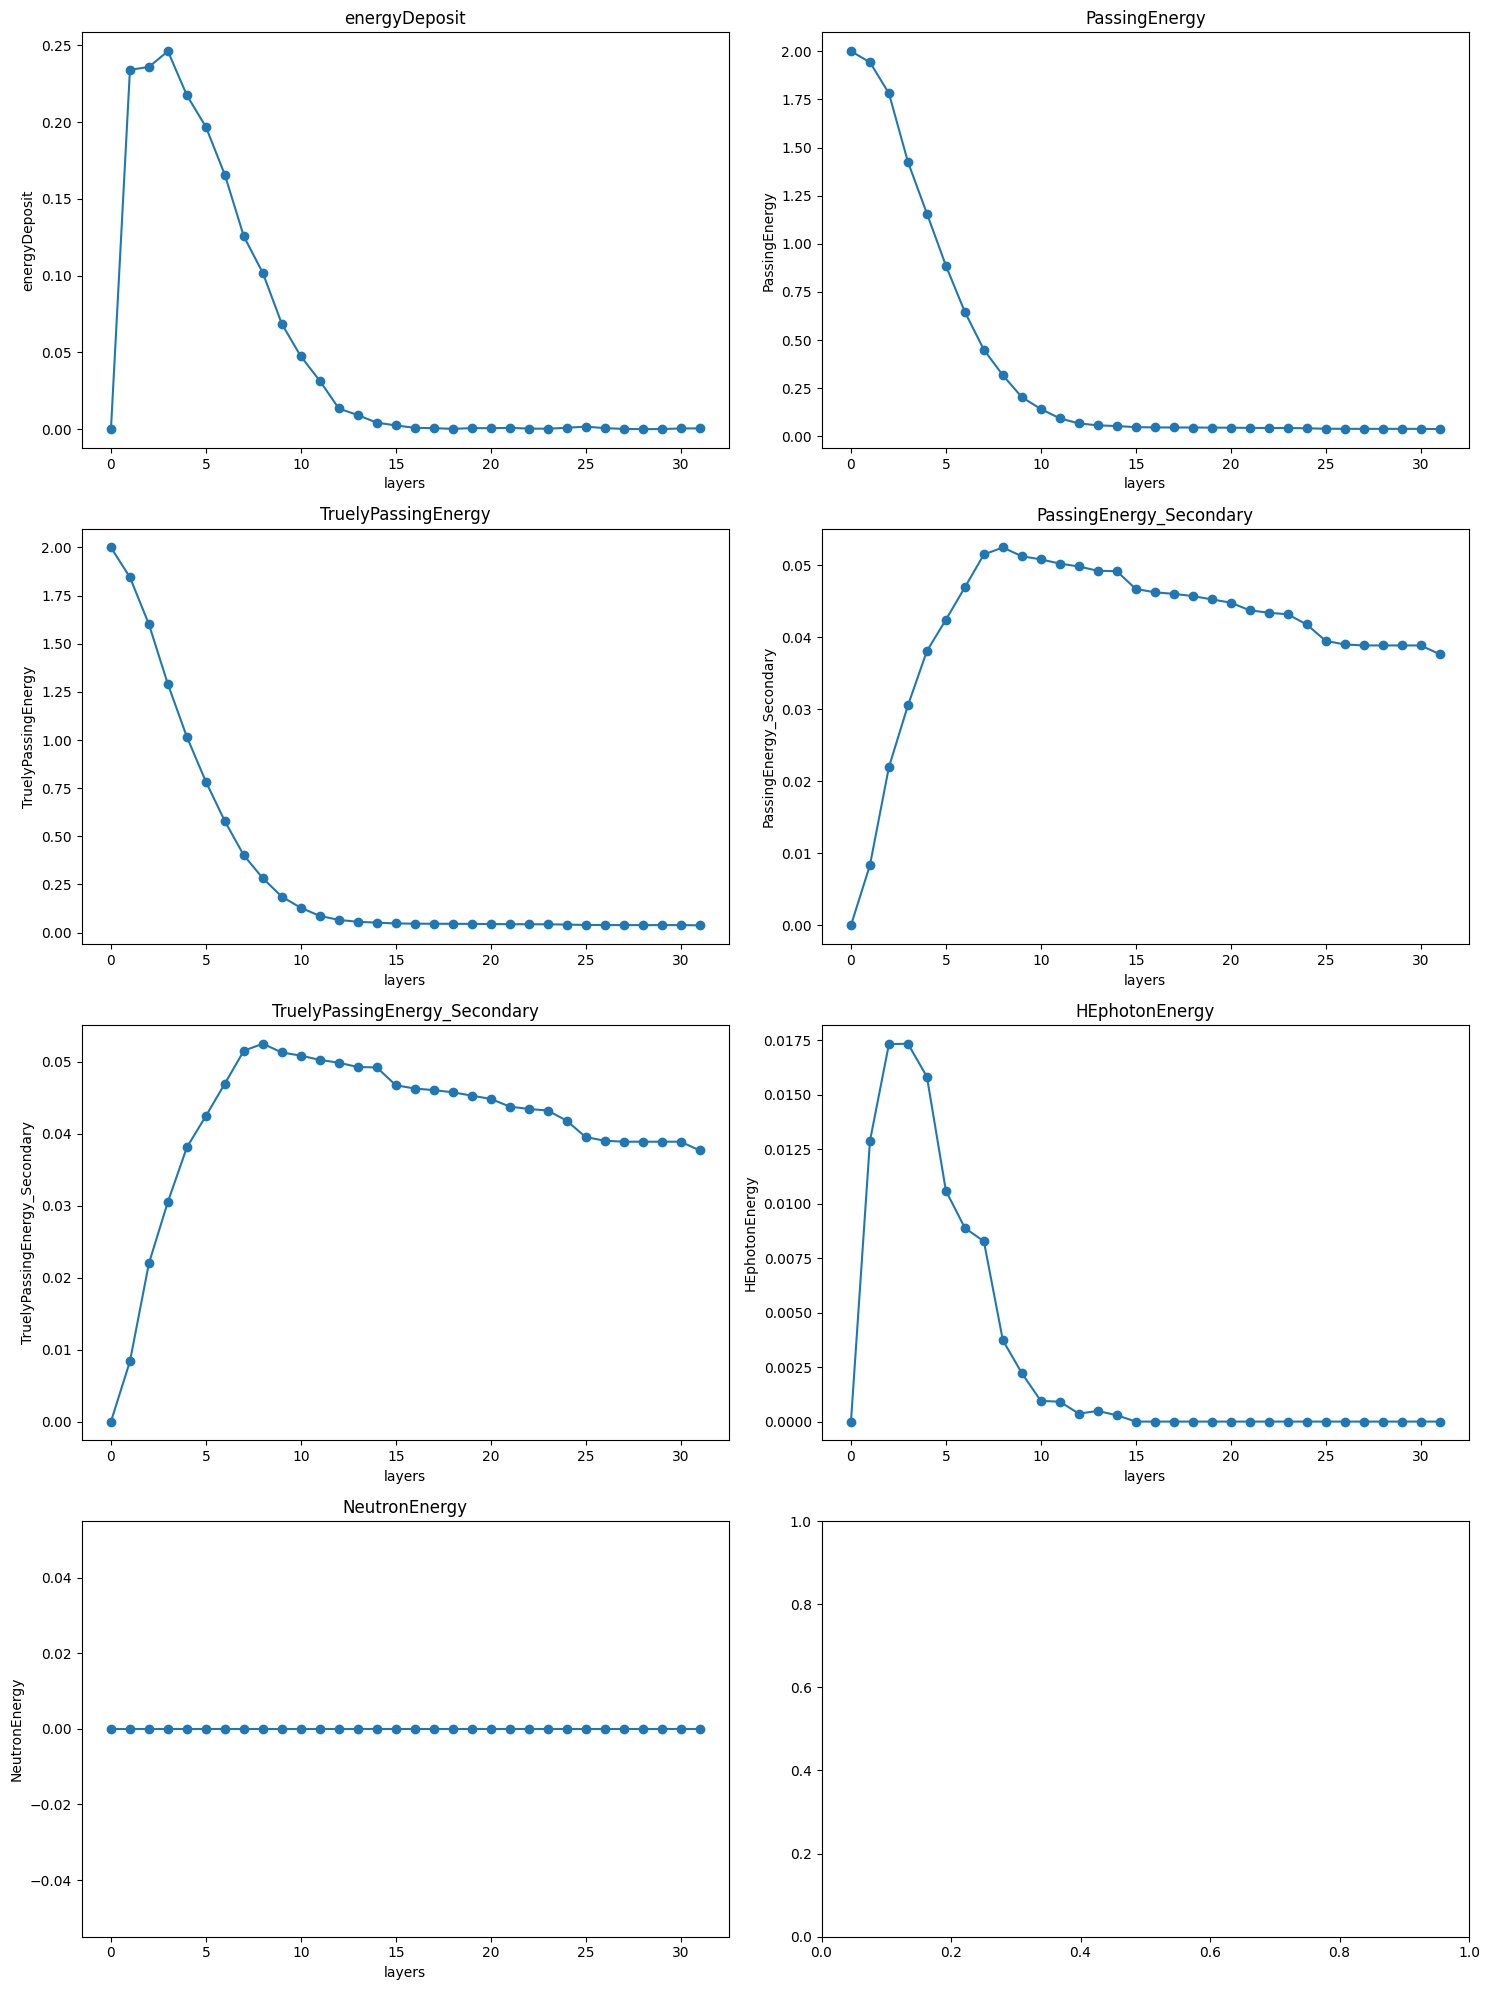

In [18]:
mean_data = fileName + r'/layers_mean.csv'
df = pd.read_csv(mean_data)
fields = df.columns[1:]
num_fields = len(fields)
num_rows = math.ceil(num_fields / 2)
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

for i, field in enumerate(fields):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.plot(df['layers'], df[field], marker='o')
    ax.set_title(field)
    ax.set_xlabel('layers')
    ax.set_ylabel(field)

plt.tight_layout()
plt.show()